# Create features

In [2]:
COMP_NAME = "used_car_price_prediction"

from pathlib import Path
CUR_DIR = Path("__file__").resolve().parent
ROOT_DIR = CUR_DIR.parent
INP_DIR = ROOT_DIR / "input" / COMP_NAME
FEAT_DIR = ROOT_DIR / "features"

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder

In [9]:
train = pd.read_csv(INP_DIR / "train_fold.csv")
train.shape

(27532, 17)

In [10]:
test = pd.read_csv(INP_DIR / "test.csv")
test.shape

(27537, 15)

## Save raw features

In [11]:
train.head()

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price,fold
0,0,nashville,1949,bmw,excellent,6 cylinders,gas,115148,clean,manual,rwd,mid-size,convertible,orange,NaN,27587,3
1,1,state college,2013,toyota,fair,8 cylinders,gas,172038,clean,automatic,rwd,full-size,sedan,silver,pa,4724,7
2,2,wichita,1998,ford,good,6 cylinders,gas,152492,clean,automatic,fwd,full-size,SUV,silver,ks,10931,6
3,3,albany,2014,ford,excellent,4 cylinders,gas,104118,clean,manual,fwd,mid-size,SUV,blue,ny,16553,1
4,4,redding,2005,ford,excellent,6 cylinders,gas,144554,clean,manual,fwd,mid-size,sedan,red,ca,5158,4


In [58]:
num_features = [
    "year",
    "odometer",
]

cat_features = [
    "region",
    "manufacturer",
    "condition",
    "cylinders",
    "fuel",
    "title_status",
    "transmission",
    "drive",
    "size",
    "type",
    "paint_color",
    "state",
]

In [59]:
train[num_features].dtypes

year        int64
odometer    int64
dtype: object

In [60]:
test[num_features].dtypes

year        int64
odometer    int64
dtype: object

In [61]:
# 連続変数はそのまま保存
for feat in num_features:
    tmp = train[["id", "fold", feat]]
    tmp.to_csv((FEAT_DIR / "train" / feat).with_suffix(".csv"), index=False)

In [63]:
# 連続変数はそのまま保存
for feat in num_features:
    tmp = test[["id", feat]]
    tmp.to_csv((FEAT_DIR / "test" / feat).with_suffix(".csv"), index=False)

In [64]:
train[cat_features].dtypes

region          object
manufacturer    object
condition       object
cylinders       object
fuel            object
title_status    object
transmission    object
drive           object
size            object
type            object
paint_color     object
state           object
dtype: object

In [31]:
# カテゴリ変数は label-encoding してから保存
encoder = OrdinalEncoder()
encoder.fit(train[cat_features])

OrdinalEncoder()

In [76]:
train_enc = pd.DataFrame(encoder.transform(train[cat_features]), columns=cat_features)
test_enc = pd.DataFrame(encoder.transform(test[cat_features]), columns=cat_features)

In [75]:
for feat in cat_features:
    tmp = train[["id", "fold"]].copy()
    tmp[feat] = train_enc[feat].astype("Int64").astype("category")
    tmp.to_csv((FEAT_DIR / "train" / feat).with_suffix(".csv"), index=False)

In [77]:
for feat in cat_features:
    tmp = test[["id"]].copy()
    tmp[feat] = test_enc[feat].astype("Int64").astype("category")
    tmp.to_csv((FEAT_DIR / "test" / feat).with_suffix(".csv"), index=False)

## Feature Engineering

### state (販売州)

region(販売地域) から欠損処理

#### eda

In [83]:
train.state.isnull().sum(), test.state.isnull().sum()

(3304, 3029)

In [86]:
train.region.nunique()

372

In [87]:
train[train.state.isnull()].region.nunique()

313

In [88]:
train[["region", "state"]].head()

,region,state
0,nashville,NaN
1,state college,pa
2,wichita,ks
3,albany,ny
4,redding,ca


In [89]:
train.query("region == 'nashville'").state.unique()

array([nan, 'tn'], dtype=object)

In [98]:
# region (販売地域) に対応する state (販売州) がいくつあるか (null 含めてmax2 ある)
train.fillna("NA").groupby("region").state.nunique().value_counts()

state
2    310
1     62
Name: count, dtype: int64

In [104]:
# null 除けば必ず１種類
train[["region", "state"]].dropna().groupby("region").state.nunique().value_counts()

state
1    369
Name: count, dtype: int64

In [108]:
region2state = train[["region", "state"]].dropna().groupby("region").state.max()
region2state.head()

region
SF bay area       ca
abilene           tx
akron / canton    oh
albany            ny
albuquerque       nm
Name: state, dtype: object

In [110]:
tmp_train = train[["region", "state"]].copy()

In [113]:
tmp_train.loc[tmp_train["state"].isnull(), "state"] = tmp_train.loc[tmp_train["state"].isnull(), "region"].map(region2state)
tmp_train.head()

,region,state
0,nashville,tn
1,state college,pa
2,wichita,ks
3,albany,ny
4,redding,ca


In [114]:
tmp_train.isnull().sum()

region    0
state     4
dtype: int64

In [115]:
# northwest KS → northwest Kansas → ks (Kansas)
# southern WV → southern West Virginia → wv (West Virginia)
# ashtabula → oh (Ohio)
tmp_train[tmp_train.state.isnull()]

,region,state
2101,northwest KS,NaN
8399,northwest KS,NaN
8630,ashtabula,NaN
13319,southern WV,NaN


In [126]:
tmp_test = test[["state", "region"]].copy()
tmp_test.loc[tmp_test["state"].isnull(), "state"] = tmp_test.loc[tmp_test["state"].isnull(), "region"].map(region2state)
tmp_test.head()

,state,region
0,co,western slope
1,or,roseburg
2,oh,akron / canton
3,co,denver
4,nc,hickory / lenoir


In [127]:
tmp_test.isnull().sum()

state     0
region    0
dtype: int64

#### region から欠損処理

In [132]:
# create mapping dict
region2state = train[["region", "state"]].dropna().groupby("region").state.max().to_dict()
region2state["northwest KS"] = "ks"
region2state["southern WV"] = "wv"
region2state["ashtabula"] = "oh"

In [133]:
tmp_train = train[["id", "fold", "region", "state"]].copy()
tmp_test = test[["id", "region", "state"]].copy()

tmp_train.loc[tmp_train["state"].isnull(), "state"] = tmp_train.loc[tmp_train["state"].isnull(), "region"].map(region2state)
tmp_test.loc[tmp_test["state"].isnull(), "state"] = tmp_test.loc[tmp_test["state"].isnull(), "region"].map(region2state)

In [134]:
tmp_train.isnull().sum()

id        0
fold      0
region    0
state     0
dtype: int64

In [135]:
tmp_test.isnull().sum()

id        0
region    0
state     0
dtype: int64

In [138]:
# カテゴリ変数は label-encoding してから保存
encoder = OrdinalEncoder()
encoder.fit(tmp_train["state"].values.reshape(-1, 1))

OrdinalEncoder()

In [141]:
tmp_train["state_fillna"] = encoder.transform(tmp_train["state"].values.reshape(-1, 1))
tmp_test["state_fillna"] = encoder.transform(tmp_test["state"].values.reshape(-1, 1))

In [142]:
tmp_train.head()

,id,fold,region,state,state_fillna
0,0,3,nashville,tn,42.0
1,1,7,state college,pa,38.0
2,2,6,wichita,ks,16.0
3,3,1,albany,ny,34.0
4,4,4,redding,ca,4.0


In [143]:
tmp_train["state_fillna"] = tmp_train["state_fillna"].astype("Int64").astype("category")
tmp_train[["id", "fold", "state_fillna"]].to_csv((FEAT_DIR / "train" / "state_fillna").with_suffix(".csv"), index=False)

In [145]:
tmp_test["state_fillna"] = tmp_test["state_fillna"].astype("Int64").astype("category")
tmp_test[["id", "state_fillna"]].to_csv((FEAT_DIR / "test" / "state_fillna").with_suffix(".csv"), index=False)

### year (製造年)
3000年代は 2000年前後に処理

#### 外れ値処理

In [147]:
map_year_outlier = lambda x: x if x < 2025 else x - 1000

In [149]:
tmp_train = train[["id", "fold", "year"]].copy()
tmp_test = test[["id", "year"]].copy()

tmp_train["year_round_outlier"] = tmp_train["year"].map(map_year_outlier)
tmp_test["year_round_outlier"] = tmp_test["year"].map(map_year_outlier)

In [151]:
tmp_train[["id", "fold", "year_round_outlier"]].to_csv((FEAT_DIR / "train" / "year_round_outlier").with_suffix(".csv"), index=False)

In [152]:
tmp_test[["id", "year_round_outlier"]].to_csv((FEAT_DIR / "test" / "year_round_outlier").with_suffix(".csv"), index=False)

### odometer (走行距離)
マイナスは非負に直す必要あり, -1はフラグにしても良いかも, マイルっぽい

#### eda

In [158]:
train.query("odometer < 0").odometer.value_counts()

odometer
-1         264
-131869      1
Name: count, dtype: int64

In [159]:
test.query("odometer < 0").odometer.value_counts()

odometer
-1    124
Name: count, dtype: int64

In [160]:
train.query("odometer == -131869")

,id,region,year,manufacturer,condition,cylinders,fuel,odometer,title_status,transmission,drive,size,type,paint_color,state,price,fold
759,759,sarasota-bradenton,2015,chevrolet,excellent,8 cylinders,gas,-131869,rebuilt,manual,rwd,full-size,SUV,blue,fl,7014,5


<Axes: ylabel='Frequency'>

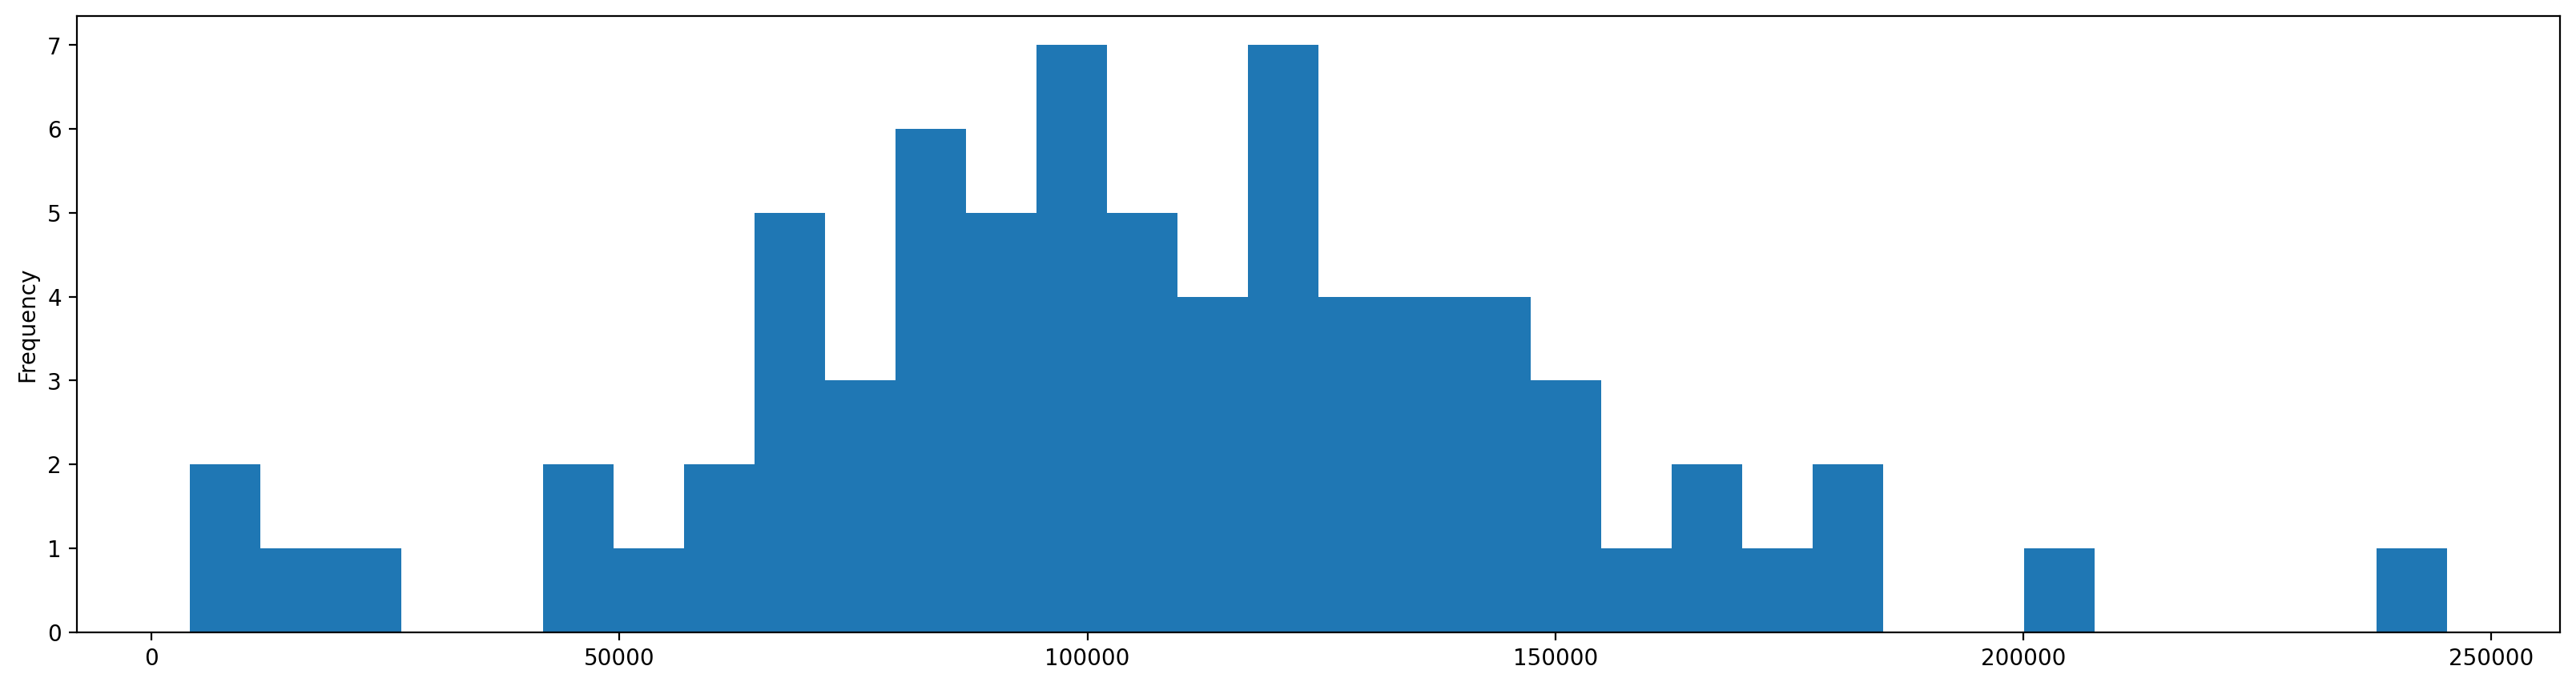

In [166]:
train.query("odometer > 0 & 6000 < price < 8000 & 2013 < year < 2017 & manufacturer == 'chevrolet'").odometer.plot(kind="hist", bins=32, figsize=(20, 5))

#### 外れ値　と -1 処理

In [168]:
# train の -131869 は 131869 に変換
tmp_train = train[["id", "fold", "odometer"]].copy()
tmp_test = test[["id", "odometer"]].copy()

tmp_train["odometer_fix_outlier"] = tmp_train["c"]
tmp_train.loc[tmp_train["odometer_fix_outlier"] == -131869, "odometer_fix_outlier"] = 131869
tmp_test["odometer_fix_outlier"] = tmp_test["odometer"]

In [176]:
# -1 フラグを作成
tmp_train["odometer_neg1"] = 0
tmp_train.loc[tmp_train["odometer"] == -1, "odometer_neg1"] = 1

tmp_test["odometer_neg1"] = 0
tmp_test.loc[tmp_test["odometer"] == -1, "odometer_neg1"] = 1

In [177]:
tmp_train[["id", "fold", "odometer_fix_outlier"]].to_csv((FEAT_DIR / "train" / "odometer_fix_outlier").with_suffix(".csv"), index=False)
tmp_train[["id", "fold", "odometer_neg1"]].to_csv((FEAT_DIR / "train" / "odometer_neg1").with_suffix(".csv"), index=False)

tmp_test[["id", "odometer_fix_outlier"]].to_csv((FEAT_DIR / "test" / "odometer_fix_outlier").with_suffix(".csv"), index=False)
tmp_test[["id", "odometer_neg1"]].to_csv((FEAT_DIR / "test" / "odometer_neg1").with_suffix(".csv"), index=False)

### manufacturer (製造メーカー)
文字列の前処理

#### eda

In [178]:
train.manufacturer.nunique()

125

In [179]:
import unicodedata
str_map = str.maketrans("аαᴄоѕ", "aacos")

In [180]:
# 全角を半角に変換 + 大文字を小文字に変換 + 名寄せ
train.manufacturer.map(lambda x: unicodedata.normalize("NFKC", x).lower().translate(str_map)).nunique(), test.manufacturer.map(lambda x: unicodedata.normalize("NFKC", x).lower().translate(str_map)).nunique()

(37, 37)

#### 文字列の前処理

In [184]:
# 名寄せ
tmp_train = train[["id", "fold", "manufacturer"]].copy()
tmp_test = test[["id", "manufacturer"]].copy()

tmp_train["manufacturer_merge"] = tmp_train.manufacturer.map(lambda x: unicodedata.normalize("NFKC", x).lower().translate(str_map))
tmp_test["manufacturer_merge"] = tmp_test.manufacturer.map(lambda x: unicodedata.normalize("NFKC", x).lower().translate(str_map))

In [188]:
# カテゴリ変数は label-encoding してから保存
encoder = OrdinalEncoder()
encoder.fit(tmp_train["manufacturer_merge"].values.reshape(-1, 1))

OrdinalEncoder()

In [189]:
tmp_train["manufacturer_merge"] = encoder.transform(tmp_train["manufacturer_merge"].values.reshape(-1, 1))
tmp_test["manufacturer_merge"] = encoder.transform(tmp_test["manufacturer_merge"].values.reshape(-1, 1))

In [192]:
tmp_train["manufacturer_merge"] = tmp_train["manufacturer_merge"].astype("Int64").astype("category")
tmp_train[["id", "fold", "manufacturer_merge"]].to_csv((FEAT_DIR / "train" / "manufacturer_merge").with_suffix(".csv"), index=False)

In [193]:
tmp_test["manufacturer_merge"] = tmp_test["manufacturer_merge"].astype("Int64").astype("category")
tmp_test[["id", "manufacturer_merge"]].to_csv((FEAT_DIR / "test" / "manufacturer_merge").with_suffix(".csv"), index=False)

### type (ボディタイプ)

In [199]:
train.groupby(["size", "cylinders", "manufacturer", "drive"]).type.nunique().value_counts()

type
1     584
2     227
3     149
4      93
5      54
6      35
7      19
8      14
9      12
0       9
10      9
11      1
13      1
12      1
Name: count, dtype: int64

### size (大きさ)

In [201]:
train["size"].nunique()

9

In [202]:
str_map = str.maketrans("ー−", "--")

In [208]:
tmp_train = train[["id", "fold", "size"]].copy()
tmp_test = test[["id", "size"]].copy()

tmp_train["size_merge"] = tmp_train["size"].map(lambda x: x.translate(str_map))
tmp_test["size_merge"] = tmp_test["size"].map(lambda x: x.translate(str_map))

In [209]:
# sub-compact < compact < mid-size < full-size
tmp_train["size_merge"].unique()

array(['mid-size', 'full-size', 'sub-compact', 'compact'], dtype=object)

In [210]:
# label-encoding
cat2labe = {
    "sub-compact": 0,
    "compact": 1,
    "mid-size": 2,
    "full-size": 3
}
tmp_train["size_merge"] = tmp_train["size_merge"].map(cat2labe)
tmp_test["size_merge"] = tmp_test["size_merge"].map(cat2labe)

In [212]:
tmp_train["size_merge"] = tmp_train["size_merge"].astype("Int64").astype("category")
tmp_test["size_merge"] = tmp_test["size_merge"].astype("Int64").astype("category")

In [213]:
tmp_train[["id", "fold", "size_merge"]].to_csv((FEAT_DIR / "train" / "size_merge").with_suffix(".csv"), index=False)
tmp_test[["id", "size_merge"]].to_csv((FEAT_DIR / "test" / "size_merge").with_suffix(".csv"), index=False)

### cylinders (気筒数)

In [220]:
train.cylinders.str.replace(" cylinders", "").unique()

array(['6', '8', '4', 'other', '10', '12', '5', '3'], dtype=object)

In [224]:
tmp_train = train[["id", "fold", "cylinders"]].copy()
tmp_test = test[["id", "cylinders"]].copy()

tmp_train["cylinders_num"] = tmp_train["cylinders"].str.replace(" cylinders", "")
tmp_train.loc[tmp_train["cylinders_num"] == "other", "cylinders_num"] = -1
tmp_train["cylinders_num"] = tmp_train["cylinders_num"].astype(int)

tmp_test["cylinders_num"] = tmp_test["cylinders"].str.replace(" cylinders", "")
tmp_test.loc[tmp_test["cylinders_num"] == "other", "cylinders_num"] = -1
tmp_test["cylinders_num"] = tmp_test["cylinders_num"].astype(int)

In [227]:
tmp_train[["id", "fold", "cylinders_num"]].to_csv((FEAT_DIR / "train" / "cylinders_num").with_suffix(".csv"), index=False)
tmp_test[["id", "cylinders_num"]].to_csv((FEAT_DIR / "test" / "cylinders_num").with_suffix(".csv"), index=False)

### fuel

### title_status

### price

In [234]:
y_min = train.price.min()
y_max = train.price.max()
y_min, y_max

(1004, 96818)

In [246]:
y_std = (train.price - y_min) / (y_max - y_min)
# y_scaled = y_std * (y_max - y_min) + y_min

In [248]:
tmp_train = train[["id", "fold"]].copy()

tmp_train["price_scaled"] = y_std

In [249]:
tmp_train.head()

,id,fold,price_scaled
0,0,3,0.277444
1,1,7,0.038825
2,2,6,0.103607
3,3,1,0.162283
4,4,4,0.043355


In [250]:
tmp_train[["id", "fold", "price_scaled"]].to_csv((FEAT_DIR / "train" / "price_scaled").with_suffix(".csv"), index=False)

In [238]:
tmp_train = train[["id", "fold", "price"]].copy()

tmp_train[["id", "fold", "price"]].to_csv((FEAT_DIR / "train" / "price").with_suffix(".csv"), index=False)